<a href="https://colab.research.google.com/github/svpino/machine-learning/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Not everyone survived the Titanic

This notebook demonstrates the use of Decision Trees to predict survivors in the Titanic.

This is an introductory exercise. I took the dataset in [this Kaggle Competition](https://www.kaggle.com/c/titanic/data), cleaned it, and transformed it into what you'll see here. My goal was to give you a dataset ready to run through a decision tree without having to worry about feature engineering.

A lot of the ideas to generate the new features came from [this notebook](https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset), authored by Diego Milla.

## Getting the data

Let's start by downloading the dataset we will be using from the GitHub repository.

Notice how using the `%%bash` magic command in a cell indicates that everything in it are bash commands.

The dataset is called `titanic.csv`, and it will be stored locally in the environment that's powering this notebook.

In [171]:
%%bash

rm titanic.csv
wget https://raw.githubusercontent.com/svpino/machine-learning/master/datasets/titanic.csv

--2020-09-24 01:51:57--  https://raw.githubusercontent.com/svpino/machine-learning/master/datasets/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19675 (19K) [text/plain]
Saving to: ‘titanic.csv’

     0K .......... .........                                  100% 2.50M=0.008s

2020-09-24 01:51:57 (2.50 MB/s) - ‘titanic.csv’ saved [19675/19675]



Now that we have the dataset, we can use `pandas` to load it. `pandas` is a handy library to deal with tabular data. It's a staple in any data scientist's toolbox, so you want to look into it as much as you can.

To load our data, we can use the `read_csv()` function. This will return a `DataFrame` object that we will store in a variable `dataset`. From now on, we will do all of our work with this variable.


In [108]:
import pandas as pd

dataset = pd.read_csv("titanic.csv")

After loading the dataset, we will display the first 10 rows to get an idea of what the data looks like. Notice that I'm using the `head()` method specifying that I want to return the top `10` rows.

Also, notice how the notebook automatically displays the value of any variables that I put alone in a line without me having to print it explicitly. This is a very useful feature of notebooks.

In [172]:
dataset.head(10)

,sex,age,fare,port,cabin,class,survived
0,1,1,0,0,0,3,0
1,0,2,3,1,1,1,1
2,0,1,1,0,0,3,1
3,0,2,3,0,1,1,1
4,1,2,1,0,0,3,0
5,1,0,1,2,0,3,0
6,1,3,3,0,1,1,0
7,1,0,2,0,0,3,0
8,0,1,1,0,0,3,1
9,0,0,2,1,0,2,1


To get a better feeling about the structure of our data, we can use the `info()` and `describe()` methods of our `DataFrame` object.

In [173]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sex       1309 non-null   int64
 1   age       1309 non-null   int64
 2   fare      1309 non-null   int64
 3   port      1309 non-null   int64
 4   cabin     1309 non-null   int64
 5   class     1309 non-null   int64
 6   survived  1309 non-null   int64
dtypes: int64(7)
memory usage: 71.7 KB


In [174]:
dataset.describe()

,sex,age,fare,port,cabin,class,survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.644003,1.359817,1.500382,0.394194,0.225363,2.294882,0.377387
std,0.478997,0.823734,1.126973,0.653499,0.417981,0.837836,0.484918
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,1.000000,1.000000,2.000000,0.000000,0.000000,3.000000,0.000000
75%,1.000000,2.000000,3.000000,1.000000,0.000000,3.000000,1.000000
max,1.000000,4.000000,3.000000,2.000000,1.000000,3.000000,1.000000


Let me try to summarize some of the information printed above about our dataset.

We have the data of `1309` passengers. For each one of these, we have the following attributes:

* `sex`: Represents the sex of the passenger, with `0` representing female, and `1` representing male.
* `age`: Each passenger is categorized into five different groups, going from 0 (for passengers 16 years old or younger) to 4 (for passengers older than 64 years old.)
* `fare`: This field groups the passengers into four different categories depending on how much they paid to get on board. It goes from `0` (those who paid less money) to `4` (those who paid more money.)
* `port`: Passengers embarked the Titanic from three different ports. 
* `cabin`: If the passenger had a cabin onboard, this field is `1`. Otherwise, it's `0`.
* `class`: The ticket class of the passenger. There are three possible values: `1` for first-class, `2` for second class, and `3` for third class.
* `survived`: This field indicates whether this passenger survived (`1`) or died (`0`).

## Preparing our datasets

Using a Machine Learning algorithm, we want to build a model capable of predicting whether a specific passenger survived the wreck.

Of course, our dataset already has that information in the `survived` field, which is great because we can build our model, and then compare our results with the value on this field to determine how we did.

The most straightforward algorithm we can use for this example is a **decision tree**. Think of it as a bunch of `if`-`else` conditions stacked together. In this case, the trick is that we want the algorithm to determine these conditions by itself.

For the algorithm to find a good set of conditions, we need to *train* it. We will show the data to the algorithm, and it will take care of finding the best approach to get as many correct answers as possible.

That being said, we don't want to show it *all* of our data. Instead, let's show it *most* of the data, but keep some aside so we can later determine whether the model is any good.

When training the model, we don't want to give the algorithm the value of the `survived` attribute as one of the columns it can use! These things are pretty smart, and if we give them the `survived` feature, it will quickly pick on it and will be able to predict the results with 100% accuracy.

Therefore, we need to remove the `survived` attribute from the dataset and store it separately. During this process, we are going to turn our data into an array so we can process it later on.

In [175]:
# First, we store the value of the survived column separately.
survived = dataset['survived'].values

# Then we drop the column from the dataset.
data = dataset.drop(['survived'], axis=1).values

At this point, we have two arrays, one containing all of the data we want to give the algorithm (`data`), and another with the results we are expecting the model to predict (`survived`). 

Now it's time to split some of the data and keep it separately, so we have something to verify that our model learned. We can do this using the `train_test_split()` function of Scikit-Learn.

Yes, **Scikit-Learn**, just like **pandas**, is another library you want to add to your toolbox. 

Using `train_test_split()` we can split both `data` and `survived` at the same time. We only need to specify what percentage of the data we want to keep in the *train* dataset (the one that we will show to the algorithm.) Everything else will go to the *test* dataset (the one we will use to make sure the model works.)

After running the function, we will end up with the following variables:

* `train_data`: The dataset containing all the data we want to show the algorithm.
* `test_data`: The dataset containing the portion of the data we will keep aside to ensure the model works. 
* `train_survived`: Whether or not each of the passengers in the `train_data` survived.
* `test_survived`: Whether or not each of the passengers in the `test_data` survived.

For this example, we are going to use 75% of the data to train the algorithm, and the remaining 25% to test it.

In [183]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_survived, test_survived = \
    train_test_split(data, survived, train_size=0.75)

Let's print each of these variables' shapes to see what we are dealing with here. This is an excellent way to ensure everything is aligned correctly.


In [184]:
print(f"Train data: {train_data.shape}")
print(f"Train results: {train_survived.shape}")

print(f"Test data: {test_data.shape}")
print(f"Test results: {test_survived.shape}")

Train data: (981, 6)
Train results: (981,)
Test data: (328, 6)
Test results: (328,)


We will be using `981` passengers to train the model, and `328` to test it and make sure it works.

## Hello decision trees!


It's time to throw a decision tree at the data and see what we get! We can use the `DecisionTreeClassifier` implementation on Scikit-Learn.

Using this classifier is extremely simple. We will show it our data, and we will let it find the appropriate set of conditions to solve the problem.

When configuring the decision tree, we want to specify how deep we want it to be. The deeper the tree is, the better it will represent the data, but we run the risk of it trying to *remember* the data instead of *understanding* it. If our tree remembers the data we are showing it, it will do very poorly as soon as we show it our test set. This is called *overfitting*, and we want to avoid it.

For this example, let's use maximum depth of `3`. Don't worry about this; I already found out that this value works reasonably well. If you are interested, finding a good value for `max_depth` is about *experimentation*. There are no fast rules here. You try a bunch of different values and pick the one that seems to work best.

Getting back to it, let's create an instance of our tree.

In [185]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)

Now that we have our tree, we can show it the data and train a model. This process is called *fitting* a model, and it requires us to give it the training dataset and the corresponding answers.

But wait. What? Isn't this cheating? We are also giving the algorithm the answers!

Yes, and no. The algorithm will only use the attributes specified in the first argument to create the underlying conditions that solve the problem. It will use the answers to test those conditions and adjust appropriately. 

In [186]:
model = decision_tree.fit(train_data, train_survived)

That's it! We now have our model!

Let's print how accurate this model is when predicting on the training data. Remember, this is the same data the model used to develop the logic to solve the problem, so we should expect this accuracy to be better than what it will be when looking at data that the model hasn't seen before.

In [187]:
accuracy = model.score(train_data, train_survived) * 100
accuracy

86.03465851172272

We get 86%, which is not bad considering that all of this has taken a few lines of code!

## Making the sure the model works 

Let's now take the dataset that we kept to ourselves and use the model to predict whether each one of the passengers survived or died. To do this, we can use the `predict()` method of our model.

In [190]:
predictions = model.predict(test_data)

To know how we did, we can use Scikit-Learn's `classification_report()` function. It will give us a bunch of interesting details.

In [191]:
from sklearn.metrics import classification_report

print(classification_report(test_survived, predictions))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       206
           1       0.78      0.80      0.79       122

    accuracy                           0.84       328
   macro avg       0.83      0.83      0.83       328
weighted avg       0.84      0.84      0.84       328



The report contains a lot of interesting metrics. Let's talk about some of them:

* We are looking at `328` total passengers. You can see this value under the `support` column in the `accuracy` row.
* Our `accuracy` is 84%. We get a slightly lower accuracy than the 86% we got on the training dataset. This is expected; our model has never seen the test dataset.
* There are `206` passengers that died and `122` passengers that survived. Notice that these are the support values for each one of our classes.
* For every 10 passengers that our model thinks died, 8.8 of them did actually die. This is the `precision` of our model for the class `0`. 
* For every 10 passengers that our model thinks survived, 7.8 of them did actually survived. This is the `precision` of our model for the class `1`.
* For every 10 passengers that died, our model can identify 8.6 of them. This is the `recall` for the class `0`.
* For every 10 passengers that survived, our model can identify 8 of them. This is the `recall` for the class `1`.

We did pretty good! I'm happy with these results!

## Looking at the tree

Finally, let's take a look at the tree that the algorithm created and is powering our model.

We are going to use the `export_graphviz()` function to generate the tree, and then I'll convert it to a PNG file.

In [193]:
features = list(dataset.drop(['survived'], axis=1))
with open("tree.dot", 'w') as f:
    tree.export_graphviz(
        model,
        out_file=f,
        feature_names = features,
        class_names = ['died', 'survived'],
        impurity = False,
        rounded = True,
        filled= True
    )

In [194]:
!dot -Tpng tree.dot -o tree.png

Let's now display the tree image here. 

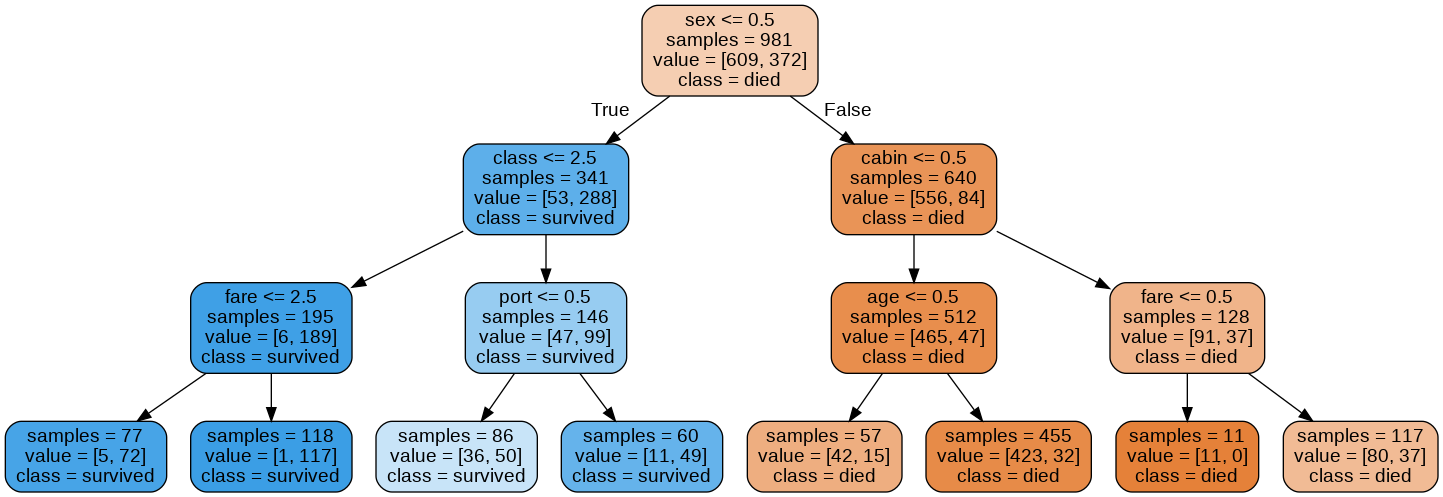

In [195]:
from IPython.display import Image
Image('tree.png')

Beautiful!

This is the process that's used by the model to classify every single passenger. Using these conditions, we get can determine whether somebody survived or died with 84% accuracy! 

Pretty good, huh?